### Price Projections for ISP Line Items Only

Pivotal Card: https://www.pivotaltracker.com/story/show/168254695

In [1]:
import math
import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
# read in csv
df = pd.read_csv("/Users/katherineaquino/Desktop/ISP-Only Line Items (All Years_States) - All ISP-only Line Items.csv")

In [3]:
df.shape

(477, 13)

In [4]:
# replace '#DIV/0!' with zeros
df.replace('#DIV/0!', 0, inplace=True)

# convert to numeric
numeric_cols = ['Monthly Circuit Cost','Bandwidth','$/Meg']
df[numeric_cols] = df[numeric_cols].astype(float)

In [5]:
df.columns

Index(['Applicant Name', 'Year', 'Line Item ID', 'District or Consortium ID',
       'State', 'Entity Type', 'Is applicant a State Network Consortium?',
       'Number of Lines', 'Function', 'Monthly Circuit Cost', 'Bandwidth',
       '$/Meg', 'Include in State Network ISP Analysis'],
      dtype='object')

### Filtering for Items to be included in the analysis

In [6]:
# excluding WV
# df_sn = df[(df['Include in State Network ISP Analysis'].isin(['Yes', 'Maybe'])) & (df.State != 'WV')]

# including WV
df_sn = df[df['Include in State Network ISP Analysis'].isin(['Yes', 'Maybe'])]

In [7]:
df_sn.shape

(107, 13)

In [8]:
df_sn.State.unique()

array(['AL', 'DE', 'GA', 'NE', 'SD', 'UT', 'WA', 'WV', 'WY', 'AR', 'ME',
       'ND'], dtype=object)

In [9]:
print(f"Number of state network states: {len(df_sn.State.unique())}")

Number of state network states: 12


In [10]:
# aggregate by median and mean, by year and state
df_agg = df_sn.groupby(['State', 'Year']).agg({'Monthly Circuit Cost': ['median', 'mean'], 
                                               '$/Meg':['median', 'mean']})

In [11]:
df_agg

Monthly Circuit Cost                    $/Meg          
                         median           mean    median      mean
State Year                                                        
AL    2015            16188.170   16188.170000  1.618817  1.618817
AR    2016            11948.000   19230.400000  1.122000  1.010880
      2017            44300.000   30963.333333  1.107500  0.874083
      2018            10300.000   21496.000000  1.030000  0.811900
      2019             9500.000    9816.666667  0.910000  0.769792
DE    2015             5476.280    5476.280000  0.547628  0.547628
      2016             7045.090    7045.090000  0.704509  0.704509
      2017             7297.550    7297.550000  0.729755  0.729755
      2018             8000.000    8000.000000  0.800000  0.800000
      2019             8000.000    8000.000000  0.800000  0.800000
GA    2015            32033.330   32033.330000  0.400417  0.400417
      2016            47216.670   47216.670000  0.393472  0.393472
      2017            66566.670   66566.670000  0.416042  0.416042
      2018            46850.000   46850.000000  0.390417  0.390417
      2019            46850.000   46850.000000  0.390417  0.390417
ME    2016             8750.000    8750.000000  0.875000  0.875000
      2017             8750.000    8750.000000  0.875000  0.875000
      2018             4750.000    4583.333333  0.400000  0.402778
      2019             4750.000    4583.333333  0.400000  0.402778
ND    2017            28400.000   28400.000000  0.710000  0.710000
      2018            11360.000   11360.000000  0.284000  0.284000
      2019            10160.000   10160.000000  0.254000  0.254000
NE    2015             8509.375    8509.375000  0.709115  0.709115
      2016             6150.000    7870.000000  0.512500  0.548333
      2017            10421.250   10421.250000  0.566250  0.566250
      2018             9409.500    9409.500000  0.376380  0.376380
      2019             3905.000    3905.000000  0.142000  0.142000
SD    2015            78160.530   78160.530000  5.582895  5.582895
      2016            21420.000   21420.000000  0.680000  0.680000
      2017             7680.000    7680.000000  0.480000  0.480000
      2018             7680.000    7680.000000  0.480000  0.480000
      2019            17280.000   17280.000000  0.480000  0.480000
UT    2015            18518.350   18518.350000  1.851835  1.851835
      2016             2173.500    7791.166667  0.217350  0.779117
      2017             7104.290    7104.290000  0.573439  0.573439
      2018            10640.000   11080.664286  0.829635  0.870784
      2019             7410.000    8395.047778  0.485833  0.454396
WA    2015             9166.000    9166.000000  0.091660  0.091660
      2016             9166.000    9166.000000  0.091660  0.091660
      2017             9166.000    9166.000000  0.091660  0.091660
      2018            15007.670   15007.670000  0.062532  0.062532
      2019            18408.340   18408.340000  0.115052  0.115052
WV    2015           395629.720  395629.720000  9.890743  9.890743
      2016           257565.920  257565.920000  4.292765  4.292765
      2017           257565.920  257565.920000  4.292765  4.292765
      2018           257774.880  257774.880000  4.296248  4.296248
      2019           273652.550  273652.550000  3.909322  3.909322
WY    2015             3400.000    3400.000000  0.340000  0.340000
      2017             5122.500    5122.500000  0.512250  0.512250
      2018             9185.500    9185.500000  0.918550  0.918550
      2019             6295.000    6295.000000  0.629500  0.629500

In [12]:
df_agg.loc['WY']

Monthly Circuit Cost            $/Meg         
                   median    mean   median     mean
Year                                               
2015               3400.0  3400.0  0.34000  0.34000
2017               5122.5  5122.5  0.51225  0.51225
2018               9185.5  9185.5  0.91855  0.91855
2019               6295.0  6295.0  0.62950  0.62950

In [13]:
df_agg.loc['WY'].index

Int64Index([2015, 2017, 2018, 2019], dtype='int64', name='Year')

In [14]:
df_agg.loc['WY'][('$/Meg', 'median')].values

array([0.34   , 0.51225, 0.91855, 0.6295 ])

In [15]:
df_agg.loc['WY'][('$/Meg', 'median')].index

Int64Index([2015, 2017, 2018, 2019], dtype='int64', name='Year')

### Plot for All State Network States: Median Cost Per Mbps

CT - plot not available
NC - plot not available
RI - plot not available
SC - plot not available
WV - plot not available


Text(0.5, 0.92, 'Median Cost Per Mbps for State Networks - ISP Only, WV Excluded')

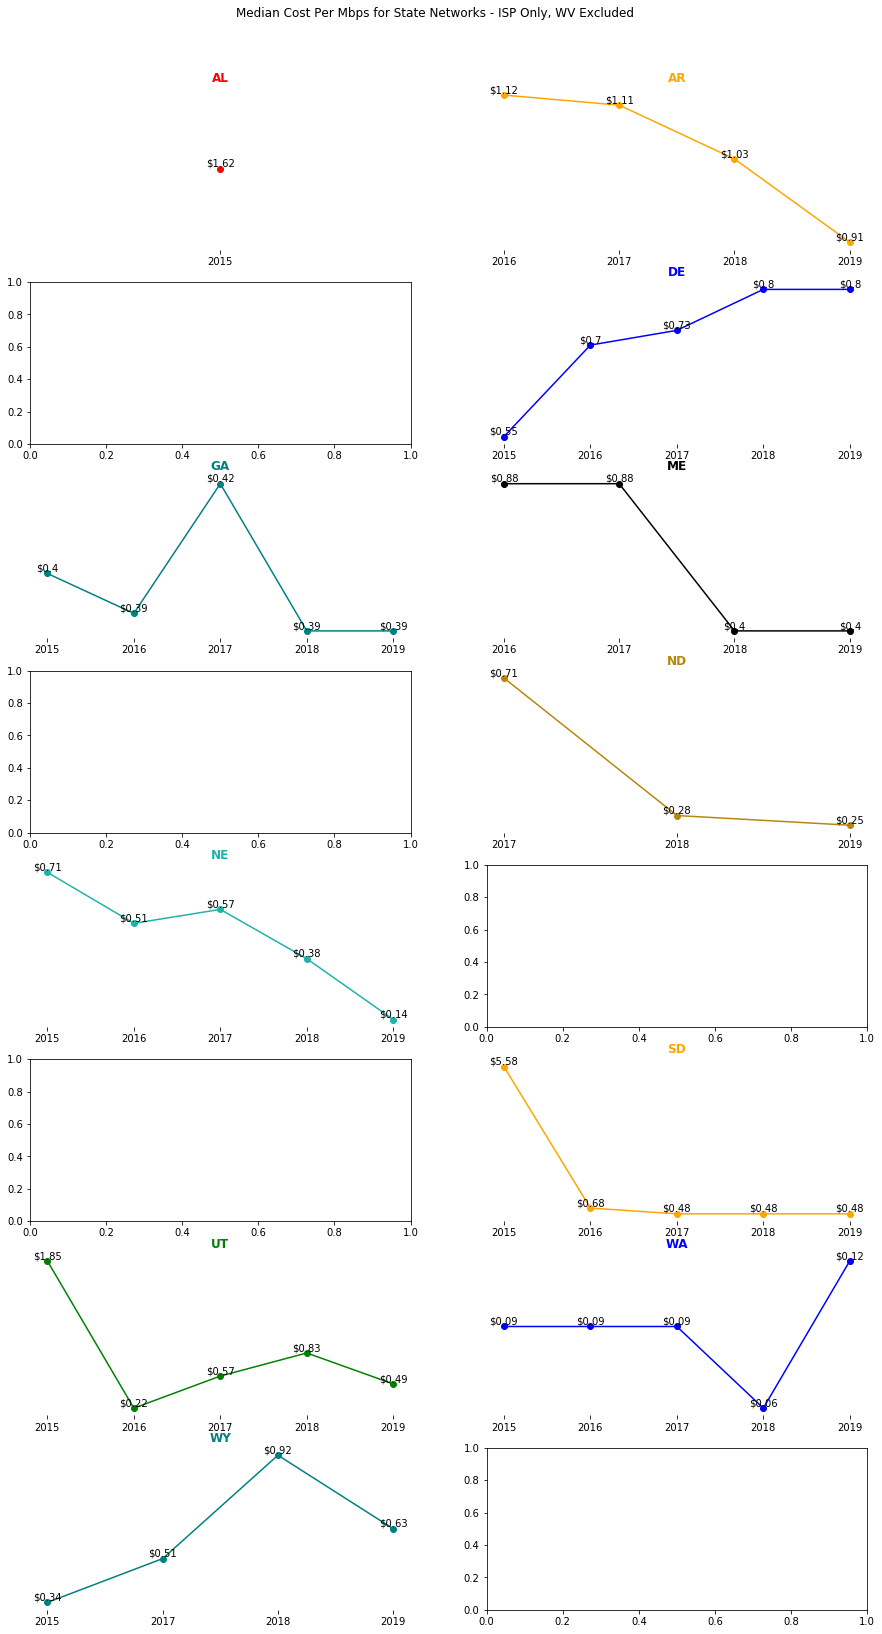

In [19]:
# Create Figure and Subplots
# 8 rows, 2 columns, 
fig, axes = plt.subplots(8, 2, sharey=False, sharex=False, figsize=(15, 28))

colors = ['red', 'orange', 'green', 'blue', 'teal', 'black', 'purple', 'darkgoldenrod', 'lightseagreen', 'deepskyblue']*2

for i, state in enumerate(['AL', 'AR', 'CT', 'DE', 'GA', 'ME', 'NC', 'ND', 'NE', 'RI', 'SC', 'SD', 'UT', 'WA', 'WY', 'WV']):
    try: 
        df_state = df_agg.loc[state]
        fy = df_state.index
        median_cost_per_mbps = df_state[('$/Meg', 'median')].values
        xmarks = np.arange(1, df_state.shape[0]+1)
        # Plot
        axes.ravel()[i].plot(xmarks, median_cost_per_mbps, marker='o', label='original', color=colors[i])
        axes.ravel()[i].set_title(state, color=colors[i], fontweight='bold')
        axes.ravel()[i].set_xticks(xmarks)
        axes.ravel()[i].set_xticklabels(fy)
        axes.ravel()[i].spines["top"].set_visible(False)
        axes.ravel()[i].spines["right"].set_visible(False)
        axes.ravel()[i].spines["left"].set_visible(False)
        axes.ravel()[i].spines["bottom"].set_visible(False)
        axes.ravel()[i].get_yaxis().set_visible(False)
        # add labels
        for x0, v0 in zip(xmarks, median_cost_per_mbps):
            axes.ravel()[i].text(x0, v0, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
    except KeyError:
        print(state + " - plot not available")
        continue
        
plt.suptitle("Median Cost Per Mbps for State Networks - ISP Only, WV Excluded", x=.5, y=.92)        
# plt.savefig("isp_only_median_cost_per_mbps_v2.png", bbox_inches='tight')

### Plot for All State Network States: Mean Cost Per Mbps

CT - plot not available
NC - plot not available
RI - plot not available
SC - plot not available


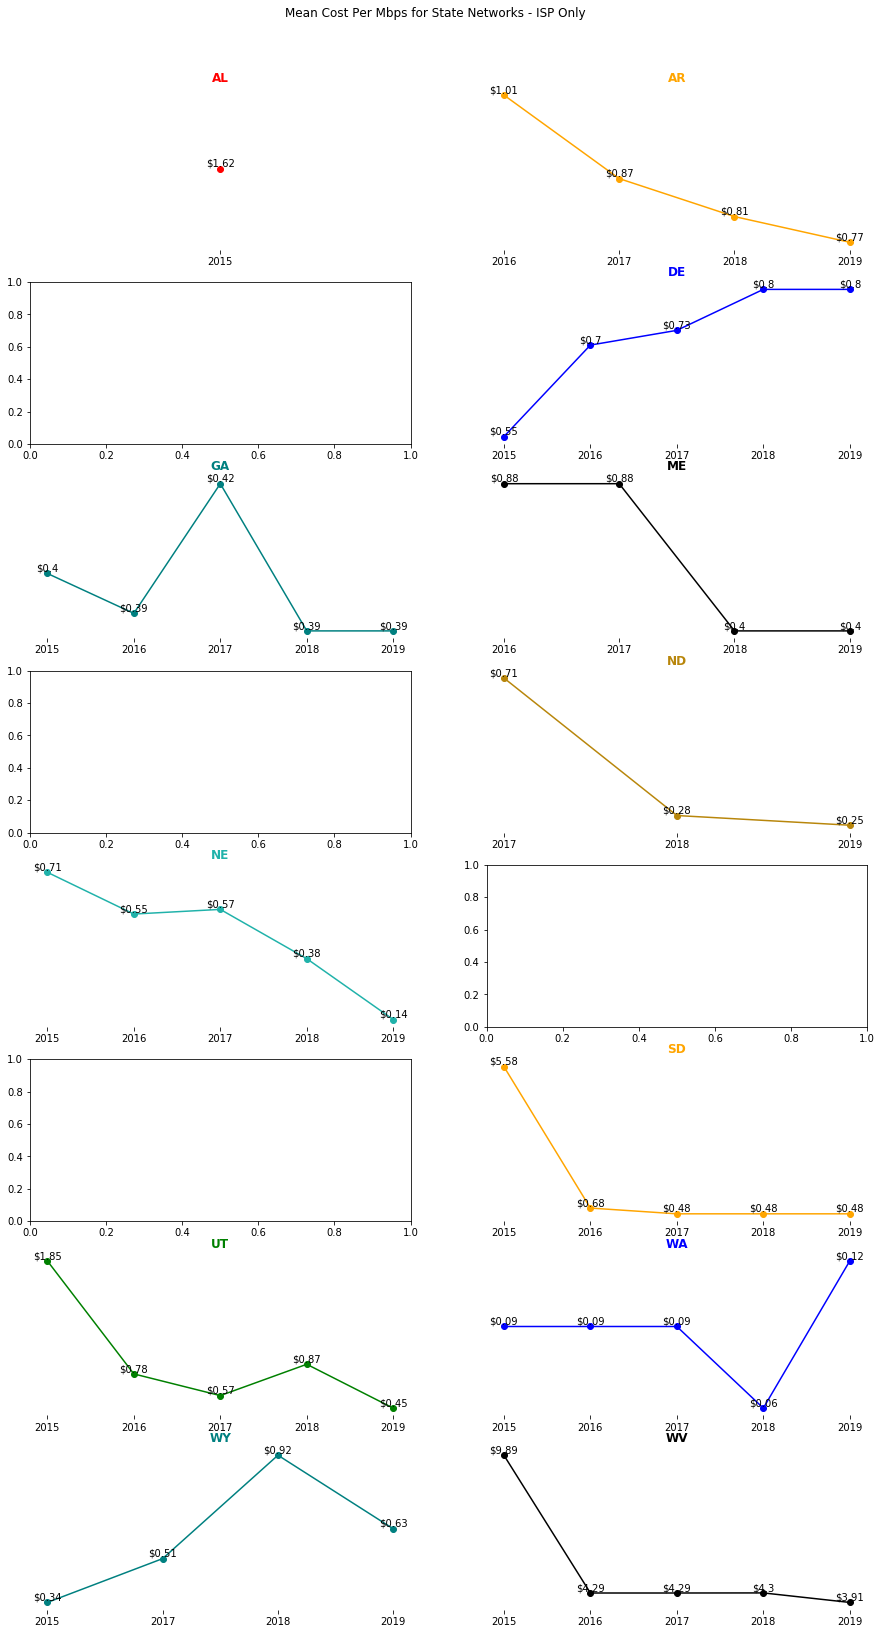

In [17]:
# Create Figure and Subplots
# 8 rows, 2 columns, 
fig, axes = plt.subplots(8, 2, sharey=False, sharex=False, figsize=(15, 28))

colors = ['red', 'orange', 'green', 'blue', 'teal', 'black', 'purple', 'darkgoldenrod', 'lightseagreen', 'deepskyblue']*2

for i, state in enumerate(['AL', 'AR', 'CT', 'DE', 'GA', 'ME', 'NC', 'ND', 'NE', 'RI', 'SC', 'SD', 'UT', 'WA', 'WY', 'WV']):
    try: 
        df_state = df_agg.loc[state]
        fy = df_state.index
        median_cost_per_mbps = df_state[('$/Meg', 'mean')].values
        xmarks = np.arange(1, df_state.shape[0]+1)
        # Plot
        axes.ravel()[i].plot(xmarks, median_cost_per_mbps, marker='o', label='original', color=colors[i])
        axes.ravel()[i].set_title(state, color=colors[i], fontweight='bold')
        axes.ravel()[i].set_xticks(xmarks)
        axes.ravel()[i].set_xticklabels(fy)
        axes.ravel()[i].spines["top"].set_visible(False)
        axes.ravel()[i].spines["right"].set_visible(False)
        axes.ravel()[i].spines["left"].set_visible(False)
        axes.ravel()[i].spines["bottom"].set_visible(False)
        axes.ravel()[i].get_yaxis().set_visible(False)
        # add labels
        for x0, v0 in zip(xmarks, median_cost_per_mbps):
            axes.ravel()[i].text(x0, v0, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
    except KeyError:
        print(state + " - plot not available")
        continue
        
plt.suptitle("Mean Cost Per Mbps for State Networks - ISP Only", x=.5, y=.92)        
plt.savefig("isp_only_mean_cost_per_mbps_v2.png", bbox_inches='tight')



### Plot for All State Network States: Median MRC

CT - plot not available
NC - plot not available
RI - plot not available
SC - plot not available


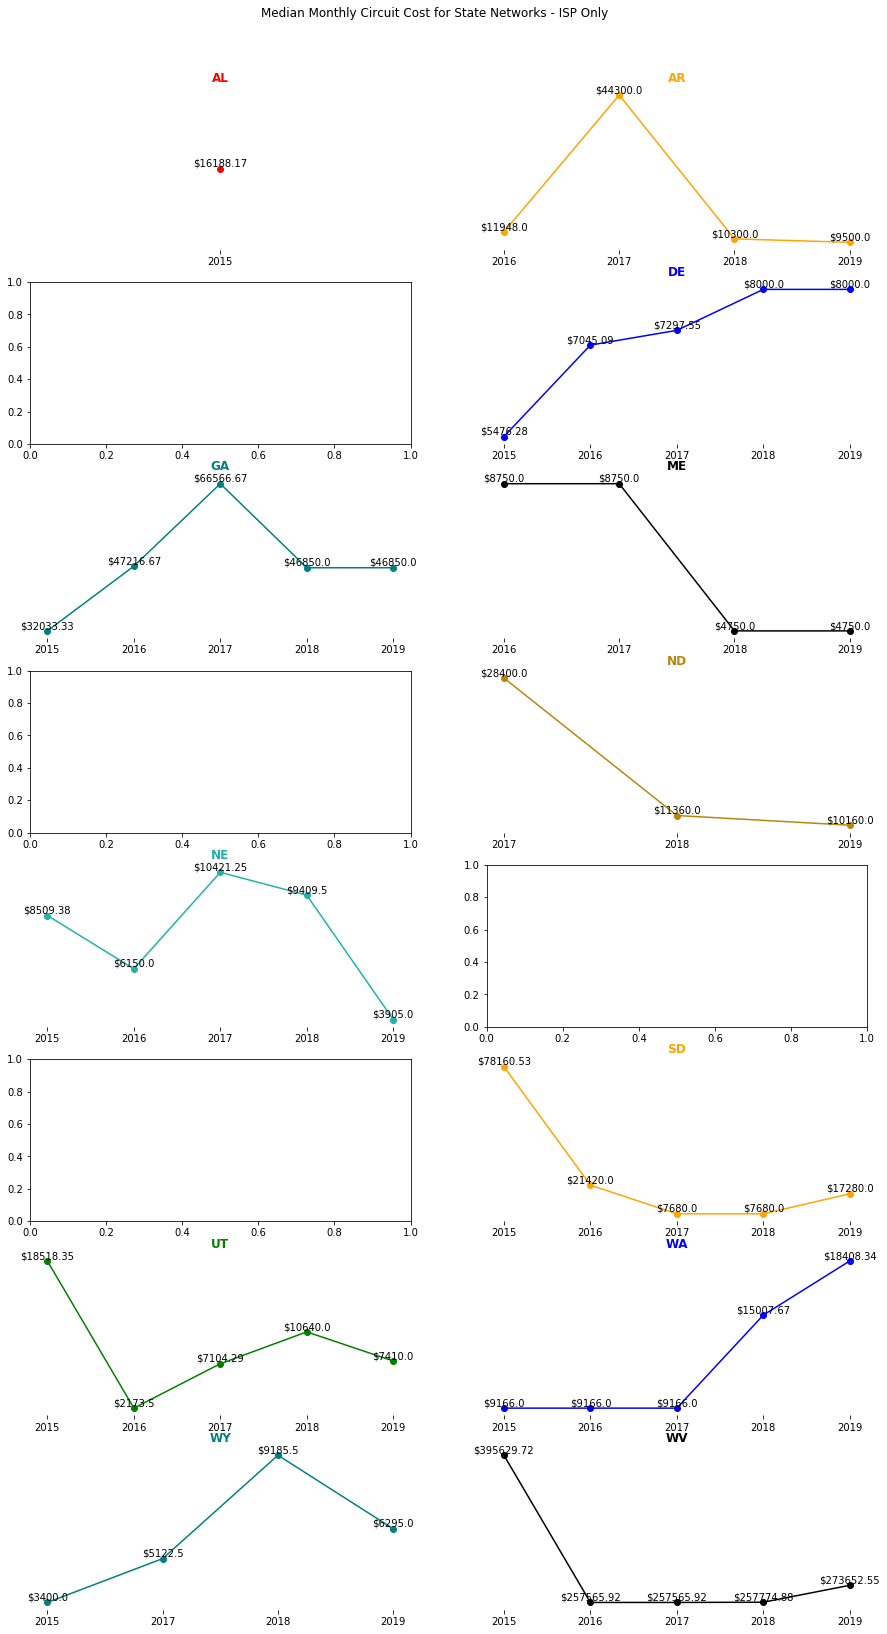

In [18]:
# Create Figure and Subplots
# 8 rows, 2 columns, 
fig, axes = plt.subplots(8, 2, sharey=False, sharex=False, figsize=(15, 28))

colors = ['red', 'orange', 'green', 'blue', 'teal', 'black', 'purple', 'darkgoldenrod', 'lightseagreen', 'deepskyblue']*2

for i, state in enumerate(['AL', 'AR', 'CT', 'DE', 'GA', 'ME', 'NC', 'ND', 'NE', 'RI', 'SC', 'SD', 'UT', 'WA', 'WY', 'WV']):
    try: 
        df_state = df_agg.loc[state]
        fy = df_state.index
        median_cost_per_mbps = df_state[('Monthly Circuit Cost', 'median')].values
        xmarks = np.arange(1, df_state.shape[0]+1)
        # Plot
        axes.ravel()[i].plot(xmarks, median_cost_per_mbps, marker='o', label='original', color=colors[i])
        axes.ravel()[i].set_title(state, color=colors[i], fontweight='bold')
        axes.ravel()[i].set_xticks(xmarks)
        axes.ravel()[i].set_xticklabels(fy)
        axes.ravel()[i].spines["top"].set_visible(False)
        axes.ravel()[i].spines["right"].set_visible(False)
        axes.ravel()[i].spines["left"].set_visible(False)
        axes.ravel()[i].spines["bottom"].set_visible(False)
        axes.ravel()[i].get_yaxis().set_visible(False)
        # add labels
        for x0, v0 in zip(xmarks, median_cost_per_mbps):
            axes.ravel()[i].text(x0, v0, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
    except KeyError:
        print(state + " - plot not available")
        continue
        
plt.suptitle("Median Monthly Circuit Cost for State Networks - ISP Only", x=.5, y=.92)        
plt.savefig("isp_only_median_monthly_cost_v2.png", bbox_inches='tight')

### Plot for All State Network States: Mean MRC

CT - plot not available
NC - plot not available
RI - plot not available
SC - plot not available


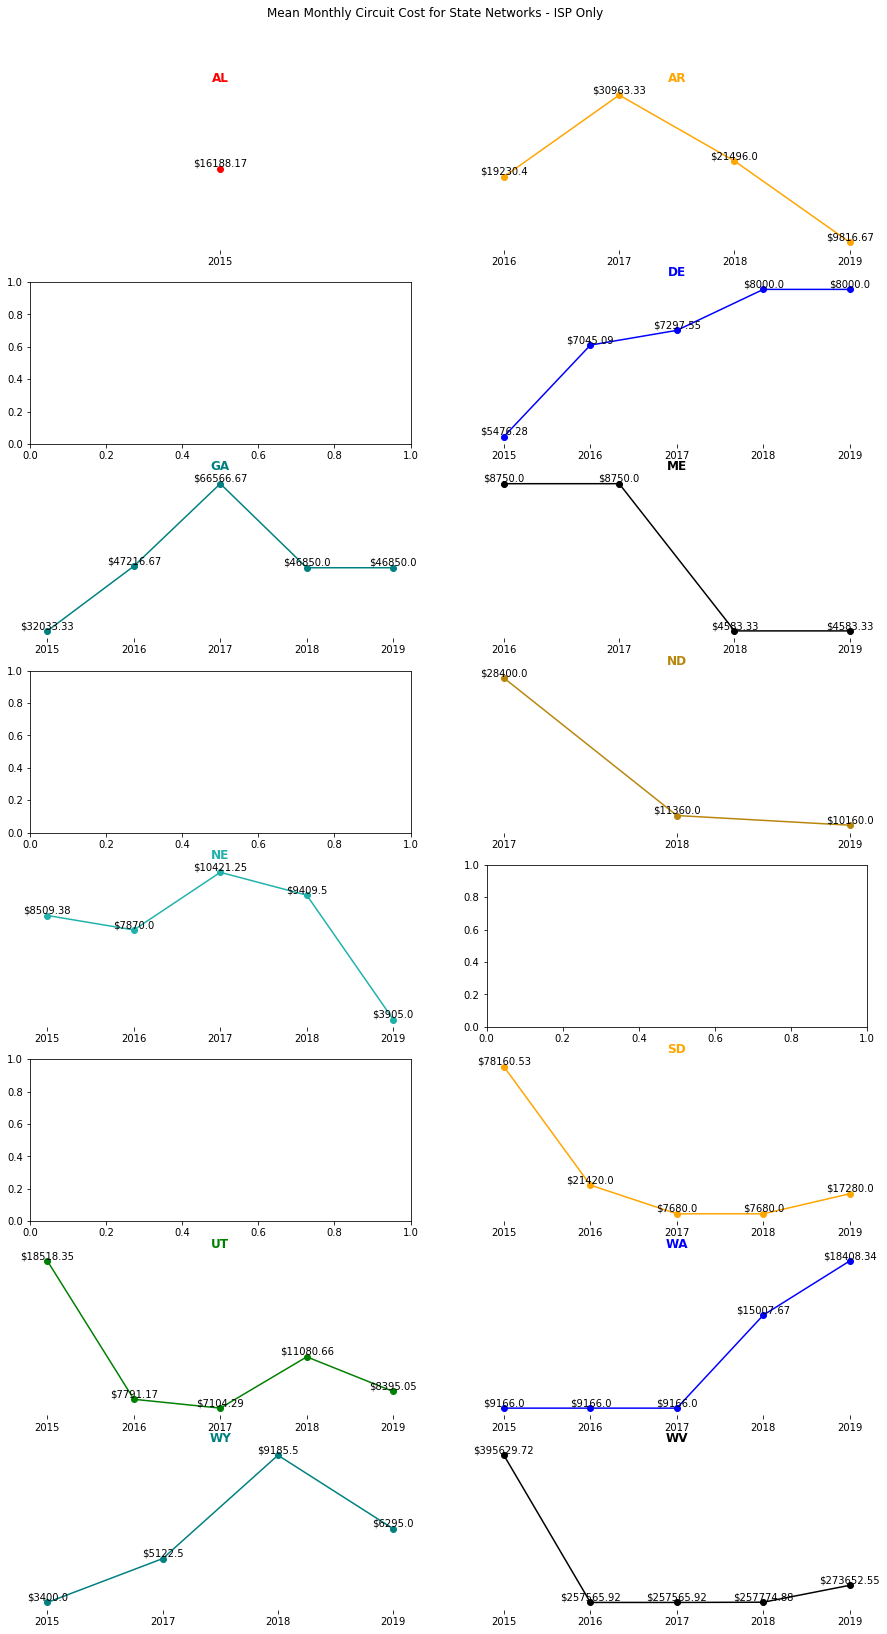

In [19]:
# Create Figure and Subplots
# 8 rows, 2 columns, 
fig, axes = plt.subplots(8, 2, sharey=False, sharex=False, figsize=(15, 28))

colors = ['red', 'orange', 'green', 'blue', 'teal', 'black', 'purple', 'darkgoldenrod', 'lightseagreen', 'deepskyblue']*2

for i, state in enumerate(['AL', 'AR', 'CT', 'DE', 'GA', 'ME', 'NC', 'ND', 'NE', 'RI', 'SC', 'SD', 'UT', 'WA', 'WY', 'WV']):
    try: 
        df_state = df_agg.loc[state]
        fy = df_state.index
        median_cost_per_mbps = df_state[('Monthly Circuit Cost', 'mean')].values
        xmarks = np.arange(1, df_state.shape[0]+1)
        # Plot
        axes.ravel()[i].plot(xmarks, median_cost_per_mbps, marker='o', label='original', color=colors[i])
        axes.ravel()[i].set_title(state, color=colors[i], fontweight='bold')
        axes.ravel()[i].set_xticks(xmarks)
        axes.ravel()[i].set_xticklabels(fy)
        axes.ravel()[i].spines["top"].set_visible(False)
        axes.ravel()[i].spines["right"].set_visible(False)
        axes.ravel()[i].spines["left"].set_visible(False)
        axes.ravel()[i].spines["bottom"].set_visible(False)
        axes.ravel()[i].get_yaxis().set_visible(False)
        # add labels
        for x0, v0 in zip(xmarks, median_cost_per_mbps):
            axes.ravel()[i].text(x0, v0, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
    except KeyError:
        print(state + " - plot not available")
        continue
        
plt.suptitle("Mean Monthly Circuit Cost for State Networks - ISP Only", x=.5, y=.92)        
plt.savefig("isp_only_mean_monthly_cost_v2.png", bbox_inches='tight')


### Run here for df_all

### All States: Median Monthly Cost

 - Defining df_all

In [16]:
# definiting df_all
df_all = df_sn.groupby('Year').agg({'Monthly Circuit Cost': ['median', 'mean'], 
                                    '$/Meg': ['median', 'mean']})
df_all

Monthly Circuit Cost                   $/Meg          
                   median          mean    median      mean
Year                                                       
2015            10140.025  49792.456667  0.790000  1.994505
2016            11948.000  29076.422353  0.645000  0.945539
2017             8750.000  32447.485263  0.645000  0.849663
2018            10300.000  23306.288000  0.532000  0.810655
2019             9500.000  17701.656471  0.508916  0.647858

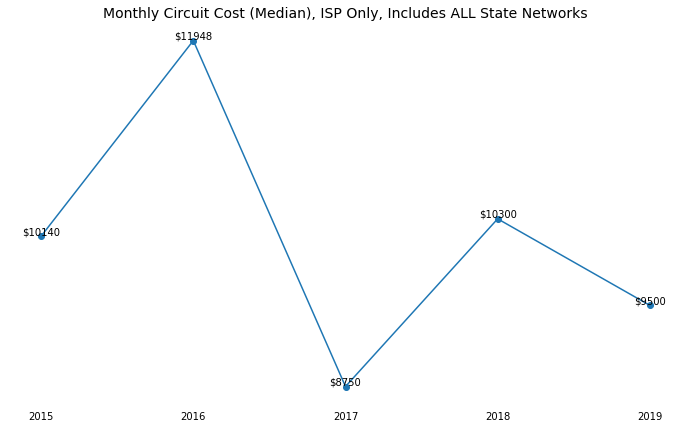

In [22]:
data_to_plot = df_all.loc[:, ('Monthly Circuit Cost','median')]

xmarks = np.arange(0, len(data_to_plot))

plt.figure(figsize=(12, 7))
plt.xticks(xmarks, data_to_plot.index)
plt.title("Monthly Circuit Cost (Median), ISP Only, Includes ALL State Networks", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.plot(xmarks, data_to_plot.values, marker='o');

# add labels
for x0, v0 in zip(xmarks, data_to_plot.values):
    plt.text(x0, v0, "$"+str(int(v0)), ha='center', va='bottom', color='black')

# save figure
plt.savefig("isp_only_median_monthly_cost_all_v2.png", bbox_inches='tight')

### All States: Mean Monthly Cost

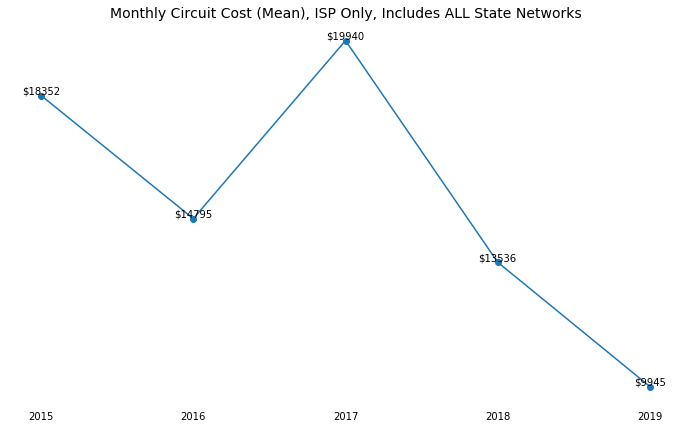

In [22]:
data_to_plot = df_all.loc[:, ('Monthly Circuit Cost','mean')]

xmarks = np.arange(0, len(data_to_plot))

plt.figure(figsize=(12, 7))
plt.xticks(xmarks, data_to_plot.index)
plt.title("Monthly Circuit Cost (Mean), ISP Only, Includes ALL State Networks", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.plot(xmarks, data_to_plot.values, marker='o');

# add labels
for x0, v0 in zip(xmarks, data_to_plot.values):
    plt.text(x0, v0, "$"+str(int(v0)), ha='center', va='bottom', color='black')

# save figure
# plt.savefig("isp_only_mean_monthly_cost_all_v2.png", bbox_inches='tight')

### All States: Median Cost Per Mbps

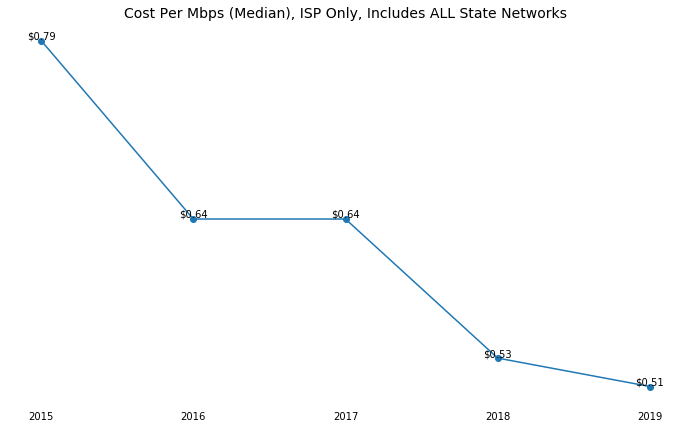

In [24]:
data_to_plot = df_all.loc[:, ('$/Meg','median')]

xmarks = np.arange(0, len(data_to_plot))

plt.figure(figsize=(12, 7))
plt.xticks(xmarks, data_to_plot.index)
plt.title("Cost Per Mbps (Median), ISP Only, Includes ALL State Networks", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.plot(xmarks, data_to_plot.values, marker='o');

# add labels
for x0, v0 in zip(xmarks, data_to_plot.values):
    plt.text(x0, v0, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')

# save figure
plt.savefig("isp_only_median_costpermbps_all_v2.png", bbox_inches='tight')

### All States: Mean Cost Per Mbps

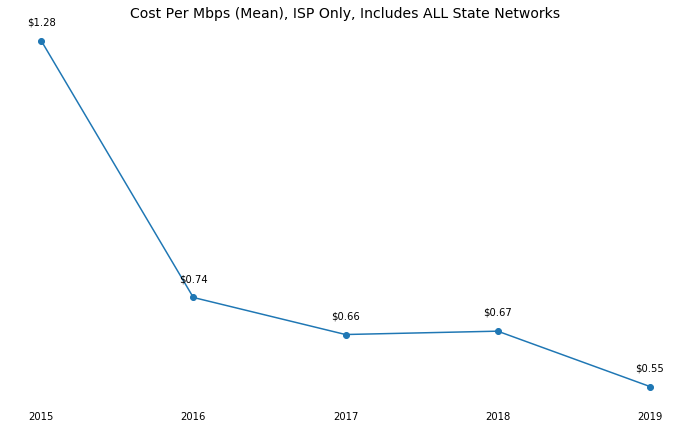

In [23]:
data_to_plot = df_all.loc[:, ('$/Meg','mean')]

xmarks = np.arange(0, len(data_to_plot))

plt.figure(figsize=(12, 7))
plt.xticks(xmarks, data_to_plot.index)
plt.title("Cost Per Mbps (Mean), ISP Only, Includes ALL State Networks", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.plot(xmarks, data_to_plot.values, marker='o');

# add labels
for x0, v0 in zip(xmarks, data_to_plot.values):
    plt.text(x0, v0+.03, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')

# save figure
# plt.savefig("isp_only_mean_costpermbps_all_v2.png", bbox_inches='tight')

### Projection: All States, Median, Cost Per Mbps

/Users/katherineaquino/anaconda3/envs/py36/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


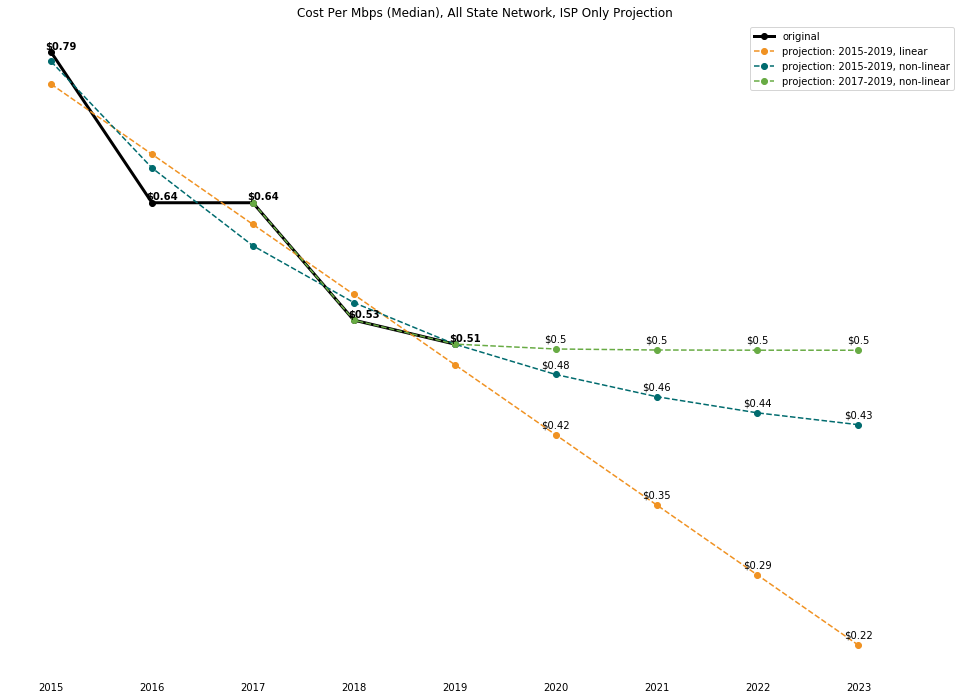

In [26]:
# original plot
data_to_plot = df_all.loc[:, ('$/Meg','median')]

xmarks = np.arange(0, len(data_to_plot))

plt.figure(figsize=(17, 12))
plt.xticks(xmarks, data_to_plot.index)
plt.title("Cost Per Mbps (Median), ISP Only, Includes ALL State Networks", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.plot(xmarks, data_to_plot.values, marker='o', label='original', color='black', linewidth=3);

# add labels
for x0, v0 in zip(xmarks, data_to_plot.values):
    plt.text(x0+.1, v0+.001, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black', fontweight='bold')
    

# projection: 2015-2019, linear
def func(x, b, c):
    return b*x + c
# fitting a curve
popt, pcov = curve_fit(func, xmarks, data_to_plot.values) 
# projecting for new values
x_new = np.arange(0, 9)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2015-2019, linear', marker='o', color='#f09222')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 4 : 
        plt.text(x0, v0+.005, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
    
    
# projection: 2015-2019, non-linear
def func(x, a, b, c):
    return a*np.exp(-b * x) + c
# fitting a curve
popt, pcov = curve_fit(func, xmarks, data_to_plot.values) 
# projecting for new values
x_new = np.arange(0, 9)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2015-2019, non-linear', marker='o', color='#006b6e')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 4:
        plt.text(x0, v0+.005, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
    
        
# projection: 2017-2019, non-linear
def func(x, a, b, c):
    return a*np.exp(-b * x) + c
# fitting a curve
popt, pcov = curve_fit(func, xmarks[2:], data_to_plot.values[2:]) 
# projecting for new values
x_new = np.arange(2, 9)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2017-2019, non-linear', marker='o', color='#68ab44')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 2:
        plt.text(x0, v0+.005, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
    

        
    
plt.legend();
plt.xticks(np.arange(0, 10), np.arange(2015, 2024));
plt.title("Cost Per Mbps (Median), All State Network, ISP Only Projection");

# save figure
# plt.savefig("projection_isp_only_median_costpermbps_all_v2.png", bbox_inches='tight')

### Projection: All States, Mean, Cost Per Mbps

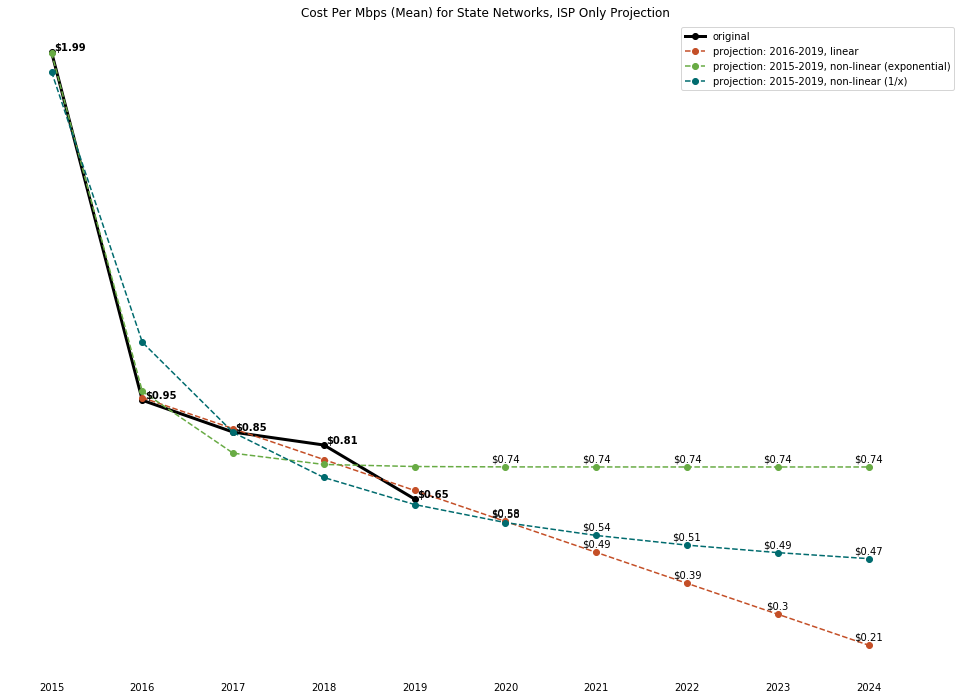

In [18]:
# original plot
data_to_plot = df_all.loc[:, ('$/Meg','mean')]

# xmarks = np.arange(0, len(data_to_plot))
xmarks = np.arange(1, len(data_to_plot)+1)

plt.figure(figsize=(17, 12))
plt.xticks(xmarks, data_to_plot.index)
plt.title("Cost Per Mbps (Mean), ISP Only, Includes ALL State Networks", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.plot(xmarks, data_to_plot.values, marker='o', label='original', color='black', linewidth=3);

# add labels
for x0, v0 in zip(xmarks, data_to_plot.values):
    plt.text(x0+.2, v0, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black', fontweight='bold')
    
# projection: 2016-2019, linear
def func(x, b, c):
    return b*x + c
# fitting a curve
popt, pcov = curve_fit(func, xmarks[1:], data_to_plot.values[1:]) 
# projecting for new values
# x_new = np.arange(1, 9)
x_new = np.arange(2, 11)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2016-2019, linear', marker='o', color='#c44f27')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 3:
        plt.text(x0, v0+.01, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
        
        
# projection: 2015-2019, non-linear
def func(x, a, b, c):
    return a*np.exp(-b * x) + c
# fitting a curve
popt, pcov = curve_fit(func, xmarks, data_to_plot.values) 
# projecting for new values
# x_new = np.arange(0, 9)
x_new = np.arange(1, 11)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2015-2019, non-linear (exponential)', marker='o', color='#68ab44')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 4:
        plt.text(x0, v0+.01, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
        
        
# projection: 2015-2019, non-linear (1/x)
def func(x, a, b, c, d):
    return a*(b/(c*x)) + d
# fitting a curve
popt, pcov = curve_fit(func, xmarks, data_to_plot.values) 
# projecting for new values
x_new = np.arange(1, 11)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2015-2019, non-linear (1/x)', marker='o', color='#006b6e')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 4:
        plt.text(x0, v0+.01, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
        
    
plt.legend();
plt.xticks(np.arange(1, 12), np.arange(2015, 2025));
plt.title("Cost Per Mbps (Mean) for State Networks, ISP Only Projection");

# save figure
plt.savefig("projection_isp_only_mean_costpermbps_091619.png", bbox_inches='tight')

### Projection: All States, Mean, Cost Per Mbps, without WV

In [19]:
# excluding WV
df_sn = df[(df['Include in State Network ISP Analysis'].isin(['Yes', 'Maybe'])) & (df.State != 'WV')]

# definiting df_all
df_all = df_sn.groupby('Year').agg({'Monthly Circuit Cost': ['median', 'mean'], 
                                    '$/Meg': ['median', 'mean']})
df_all

Monthly Circuit Cost                   $/Meg          
                   median          mean    median      mean
Year                                                       
2015             9480.050  18352.705455  0.680000  1.276665
2016            11779.000  14795.828750  0.621200  0.736337
2017             8739.490  19940.905556  0.637250  0.658380
2018             9298.175  13536.763333  0.506000  0.665422
2019             9500.000   9945.568788  0.485833  0.549026

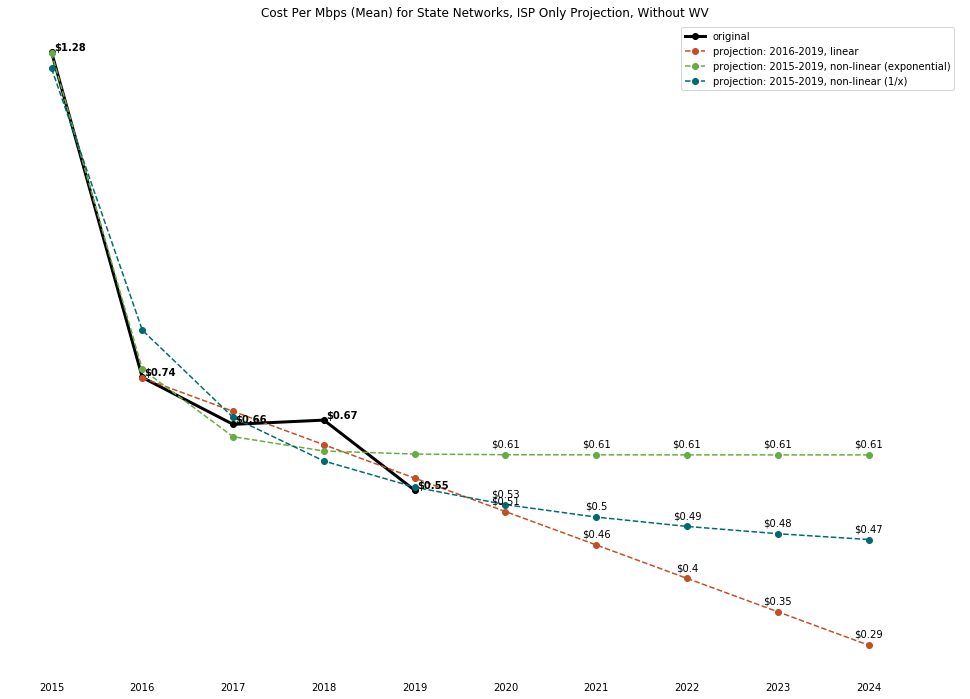

In [22]:
# original plot
data_to_plot = df_all.loc[:, ('$/Meg','mean')]

# xmarks = np.arange(0, len(data_to_plot))
xmarks = np.arange(1, len(data_to_plot)+1)

plt.figure(figsize=(17, 12))
plt.xticks(xmarks, data_to_plot.index)
plt.title("Cost Per Mbps (Mean), ISP Only, Includes ALL State Networks", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.plot(xmarks, data_to_plot.values, marker='o', label='original', color='black', linewidth=3);

# add labels
for x0, v0 in zip(xmarks, data_to_plot.values):
    plt.text(x0+.2, v0, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black', fontweight='bold')
    
# projection: 2016-2019, linear
def func(x, b, c):
    return b*x + c
# fitting a curve
popt, pcov = curve_fit(func, xmarks[1:], data_to_plot.values[1:]) 
# projecting for new values
# x_new = np.arange(1, 9)
x_new = np.arange(2, 11)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2016-2019, linear', marker='o', color='#c44f27')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 3:
        plt.text(x0, v0+.01, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
        
        
# projection: 2015-2019, non-linear
def func(x, a, b, c):
    return a*np.exp(-b * x) + c
# fitting a curve
popt, pcov = curve_fit(func, xmarks, data_to_plot.values) 
# projecting for new values
# x_new = np.arange(0, 9)
x_new = np.arange(1, 11)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2015-2019, non-linear (exponential)', marker='o', color='#68ab44')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 4:
        plt.text(x0, v0+.01, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
        
        
# projection: 2015-2019, non-linear (1/x)
def func(x, a, b, c, d):
    return a*(b/(c*x)) + d
# fitting a curve
popt, pcov = curve_fit(func, xmarks, data_to_plot.values) 
# projecting for new values
x_new = np.arange(1, 11)
plt.plot(x_new, func(x_new, *popt), 
         '--', label='projection: 2015-2019, non-linear (1/x)', marker='o', color='#006b6e')
# add labels
for i, (x0, v0) in enumerate(zip(x_new, func(x_new, *popt))):
    if i > 4:
        plt.text(x0, v0+.01, "$"+str(round(v0, 2)), ha='center', va='bottom', color='black')
        
    
plt.legend();
plt.xticks(np.arange(1, 12), np.arange(2015, 2025));
plt.title("Cost Per Mbps (Mean) for State Networks, ISP Only Projection, Without WV");

# save figure
plt.savefig("projection_isp_only_mean_costpermbps_091619_without_WV.png", bbox_inches='tight')

In [23]:
df_sn.State.unique()

array(['AL', 'DE', 'GA', 'NE', 'SD', 'UT', 'WA', 'WY', 'AR', 'ME', 'ND'],
      dtype=object)